# Power Spectra, Semivariograms, and Structure Functions: A “Rosetta Stone” for Studies of Spatial Variation in Astrophysical Data

This notebook accompanies the pedagogical note (Metha & Berger, 2024) as a numerical reference in Python. We start with a 2D second-order stationary random field (RaFiel) and present each method described in the note. We also show the output from our methods on a 2D Gaussian random noise field (RaNois). We attempt to provide the simplest implementation of the semivariogram, power spectrum, and structure function. We do not consider efficiency in our implementations. We also do not use consistent Python snake case throughout this tutorial, but we want to keep our field names consistent with the note. 

If you do use any of our power spectrum, semivariogram, or structure function code, please let us know by citing [arXiV link].

We're astronomers! Of course we start out notebooks by importing numpy, matplotlib, and scipy!

In [66]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

We use colorblind friendly plots! Please install cblind to do this.

In [67]:
#%pip install cblind # 

In [68]:
import cblind as cb
cmap = cb.cbmap('cb.bird')

/var/folders/57/59_c7jss5dd3jh7w6c724nv80000gn/T/ipykernel_82381/2274111421.py:2: DeprecationWarning: cblind.cbmap is deprecated. Please use matplotlib.colormaps.get_cmap instead, or matplotlib.pyplot.get_cmap if you need to specify nbin (default is 256)
  cmap = cb.cbmap('cb.bird')


## Load in our random field!
You get to choose which random field to use! By default, we load in the standard RaFiel used throughout the note, but you can load in the other fields shown in Figure 1 of the Note by uncommenting the line below and specifying a field number.

In [69]:
# To keep same data, load in the previously saved RF
RaFiel = np.load('Data/RaFiel.npy') 
# RaFiel = np.load('Data/rf_X.npy') where X is is a number between 0 and 5. Try it out!


## Here's the random field we'll be exploring to quantify spatial correlations

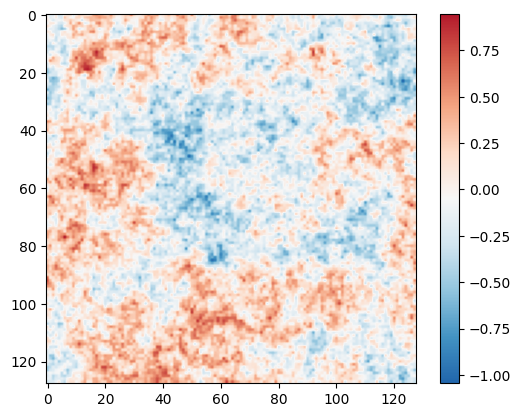

In [70]:
# Note that we're only using the real part of RaFiel. There is some imaginary
# component due to the ianccuracies in discrete numerical Fourier transform computation.
plt.imshow(np.real(RaFiel), cmap=cmap) 
plt.colorbar()

# Computing a power spectrum

This technique comes from the cosmologist's toolbox, and is described in Section 4.1 of [arXiV link]. Below we present a function to calculate the 1D power spectrum for our 2D field:

In [71]:
def circular_binned_pspec(field, nbins):
    """
    This function takes a 2D square field and calculates
    the 1D power spectrum (implementation of Section 3.1.1 in Note). 
    It is equivalent to the Fourier transform of the covariance matrix of a mean zero field.

    We are doing the following numerically:
    1) Take the Fourier transform of a field 
    2) Average the Fourier transformed field in concentric circular bins (rings) in k space,
    assuming isotropic, translationally invariant data. 
    3) Square the data and work out the units.

    *We maintain the classic cosmology Fourier spectrum conventions 
    (mostly this just means extra factors of $2 \pi$).

    Parameters
    ----------
    field: (n,m) numpy array
        A random field, whose power spectrum we are trying to compute

    nbins: int
        Number of bins to use

    resolution: float
        Resolution of the data. This is to ensure your final power spectrum ends up in
        the right units.
    
    Returns
    -------

    counts: (n) numpy array
        The number of k modes in each bin

    pspec: (n) numpy array
        The (1D) power spectrum computed for this random field

    bin means: (same as pspec) numpy array
        Mean value of k_modes within particular bins
    """
    curr_side_length = np.shape(field)[0] # side length of the field
    #  FFTed field with proper FFTshifting
    fft_data = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(field))) 
    fft_data_squared = np.abs(fft_data**2)

    # organizing k array
    k_arr = np.fft.fftshift(np.fft.fftfreq(curr_side_length)) * 2 * np.pi # k_arr has units of 1/pixels
    # k_arr *= resolution # to ensure that k_arr is in the units of your sidelength, multiply by pixels/side length
    # unfold 1D k_arr into k_x and k_y, the Fourier modes corresponding to each pixel in fft_data
    k1, k2 = np.meshgrid(k_arr, k_arr)     
    k_mag_full = np.sqrt(k1 ** 2 + k2 ** 2) # get an array of k magnitudes

    # getting number of k_modes in each bin and sides of bins
    counts, bin_edges = np.histogram(k_mag_full, nbins)

    """
    Below is one of the trickiest lines so take a second to think about it.
    Essentially, we're doing the same thing as we did to get the bin edges and counts, but
    this time we're weighting by the data we actually care about, fft_data.
    This is summing up the power in each concentric ring (or bin) of our fft_data field.
    """
    binned_fft_data, _ = np.histogram(k_mag_full, nbins, weights=fft_data_squared)

    # below we're getting the mean k value in each bin
    bin_means = (np.histogram(k_mag_full, nbins, weights=k_mag_full)[0] /
                 np.histogram(k_mag_full, nbins)[0])

    pspec = binned_fft_data / counts # squaring the binned data to get the average power in each bin

    # Our pspecs units are currently, pixels^4, we want Mpc^2.
    area = curr_side_length**2
    pspec /= area # We divide by the area (number of pixels) to convert from pixels^4 --> pixels^2.
    # pspec *= (1/resolution)**2 # We multiply by 1/resolution to go from pixels^2 --> Mpc^2 if we want to!
    return counts, pspec, bin_means

We calculate the power spectrum of RaFiel with 32 bins below:

In [72]:
counts, pspec, bin_means = circular_binned_pspec(RaFiel, 32)

Below we plot the theory power spectrum that went into making RaFiel (see Appendix) and the power spectrum of this realization of RaFiel:

<Figure size 800x1200 with 0 Axes>

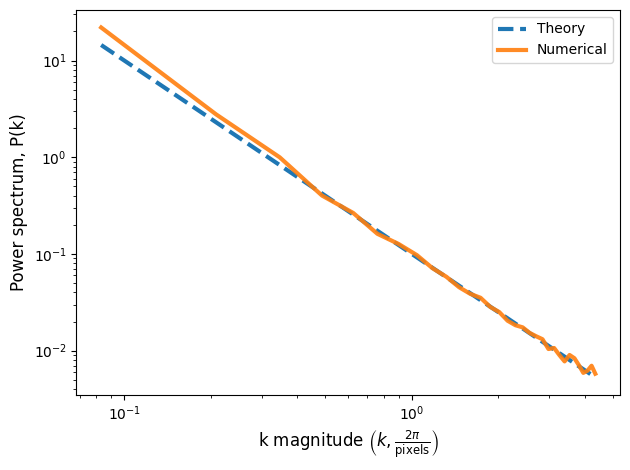

In [73]:
plt.figure(figsize=(8, 12))
fig, ax = plt.subplots()
pspec_theory = 0.1 * bin_means ** -2 # this is the power spectrum used to generate RaFiel
plt.loglog(bin_means, pspec_theory, linewidth=3, label="Theory", ls="--")
plt.loglog(bin_means, pspec, linewidth=3, label="Numerical", alpha=0.9)
plt.xlabel(r"k magnitude $\left(k, \frac{2 \pi}{\rm pixels}\right)$", fontsize=12)
plt.ylabel("Power spectrum, P(k)", fontsize=12)
plt.legend()
plt.tight_layout()

### What's the minimum (pixel) distance we can look for correlations with the power spectrum for RaFiel?

In [74]:
minimum_distance = 2*np.pi/np.max(bin_means)
print(f"The minimum distance is {minimum_distance} pixels.")

The minimum distance is 1.4471262439385244 pixels.


### What's the maximum (pixel) distance we can look for correlations with the power spectrum for RaFiel?

In [75]:
side_length = np.shape(RaFiel)[0]
maximum_distance = side_length
print(f"The maximum distance is {maximum_distance} pixels, or just the side length of the box.")

The maximum distance is 128 pixels, or just the side length of the box.


# Computing a semivariogram

This technique comes from the geostatistician's toolbox, and is described in Section 4.1 of [arXiV link]. It leads very nicely into our implementation of the structure function so we present it second. Below we present a function to calculate the semivariogram:

In [76]:
def get_semivariogram(Z, dist_matrix, bin_size = 3, f_keep=1.0):
    '''
    Computes the empirical semivariogram in each bin

    Parameters
    ----------
    Z : array-like (m,)
        The variable we are making a semivariogram of. 
        Usually residuals in metallicity.
        But if you're Ryan, it's probably the velocity once you've detrended it.

    dist_matrix: np array (m, m)
        Gives the distance from all pairs of points.
        Comes from deprojected_distances, so units are kpc.
        
    bin_size: float
        size of bins. Same units as dist_matrix
        Here I'll default to 100 pc -- but it's good to use a couple of pixel widths.
        
    f_keep: float
        Famously semivariograms get unreliable as you go out to high distances
        But for right now I'm into that.
        So keep all of them (default to 1)
        
    Returns
    -------
    semivariogram: array
        Value of empirical semivariogram in each bin

    bins: array
        Location of the bins. For plotting.

    n_pairs_per_bin: array
        # of pairs of data points used to compute the semivariance in each bin.
        Good for diagnostics - maybe you want to cut off after the first bin
        with n_pairs < 20 or so?
    '''
    m = len(Z)
    bins = np.arange(0, np.max(np.max(dist_matrix)), bin_size)
    dif_pairs = [[] for x in bins]
    for i in range(m):
        for j in range(i+1,m):
            bin_index = int(np.floor(dist_matrix[i,j]/bin_size))
            dif_pairs[bin_index].append(Z[i]-Z[j])
    # Now get variance for each bin
    semivariogram = 0.5 * np.array([np.var(x, ddof=1) for x in dif_pairs])
    n_pairs_per_bin = [len(x) for x in dif_pairs]
    max_i = int(len(bins)*f_keep)
    return semivariogram[:max_i], bins[:max_i], n_pairs_per_bin[:max_i]

Next we assign coordinates to each pixel, calculate the distance matrix for all points, and calculate the semivariogram:

In [77]:
# Make arrays for the positions of each pixel
x       = np.arange(side_length)
y       = np.arange(side_length)
X, Y    = np.meshgrid(x, y)
coords_of_each_pixel = np.vstack((X.flatten(), Y.flatten())).T

# creates the matrix in which to put the distances between all points:
from sklearn.metrics.pairwise import euclidean_distances 
distance_matrix      = euclidean_distances(coords_of_each_pixel)

svg, bin_centers, counts = get_semivariogram(RaFiel, distance_matrix, bin_size=3.0)

/Users/sabrinaberger/anaconda3/envs/ili-torch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sabrinaberger/anaconda3/envs/ili-torch/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/sabrinaberger/anaconda3/envs/ili-torch/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Next we plot the semivariogram (this is Figure 3 from the Note):

(0.0, 65.0)

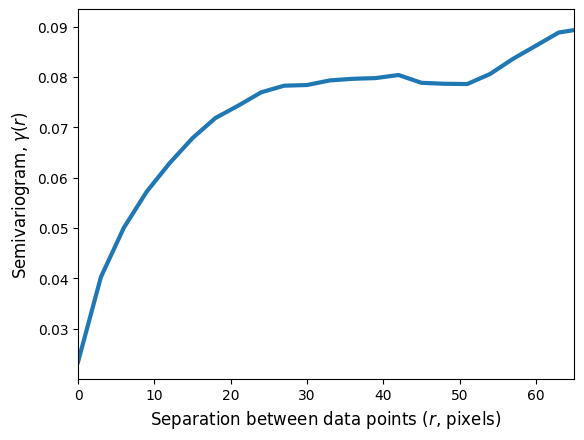

In [78]:
plt.plot(bin_centers, svg, linewidth=3)
plt.xlabel("Separation between data points ($r$, pixels)", fontsize=12)
plt.ylabel("Semivariogram, $\gamma(r)$", fontsize=12)
plt.xlim(0,65) # After sep = 1/2 box size, things look strange -- change the limit and see for yourself!
# So RaFiel is correlated over a distance of about 30 pixels, and he has a variance of about 6?

# Computing a structure function

This technique comes from the fluid dynamicist's toolbox, and is described in Section 4.3 of [arXiV link]. As described in the Note, the semivariogram and structure function differ only by a factor. Below we define a function to calculate the structure function using our definition of the semivariogram:

In [86]:
def get_structure_function(Z):
    '''
    Computes the empirical semivariogram in each bin

    Parameters
    ----------
    Z : array-like (m,)
        The variable we are making a structure function of.         
    Returns
    -------
    structure function: array
        Value of empirical structure function in each bin
    '''
    N, M = Z.shape
    svg, bin_centers, counts = get_semivariogram(Z, distance_matrix)
    return 2*(M*N-1)/(M*N) * svg, bin_centers, counts
    # We use the distance matrix defined above

Next we plot the structure function:

(0.0, 65.0)

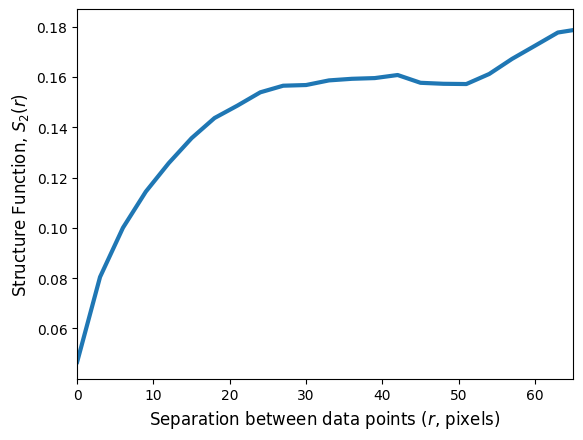

In [87]:
structure_function, bin_centers, counts = get_structure_function(RaFiel)
plt.plot(bin_centers, structure_function, linewidth=3) # yep, it's just 2 times the semivariogram :)
plt.xlabel("Separation between data points ($r$, pixels)", fontsize=12)
plt.ylabel("Structure Function, $S_2(r)$", fontsize=12)
plt.xlim(0,65) # After sep = 1/2 box size, things look strange -- change the limit and see for yourself!
# So RaFiel is correlated over a distance of about 30 pixels, and he has a variance of about 6?

# Appendix: How did we make RaFiel?

We present one way of generating a random field, but there are many! This one involves multiplying a Gaussian white noise field with the power spectrum in Fourier space, or equivalently, convolving the field with the covariance matrix. (Remember convolutions are just multiplications in Fourier space!) You can also just load in RaFiel.npy to produce the same results.

### 1) Generate some Gaussian random noise

We choose a 2D field with side lengths that are powers of 2. Powers of 2 work better in the Fast Fourier Transform (FFT) world, but it won't matter too much for us. This is due to the runtime of FFTs decreasing from $O(N^2)$ to $O(\rm N\log~N)$ when using shapes that are in powers of 2. Modern FFT implementations do not require it as critically for runtime, but the convention remains common.

In [88]:
side_length = 128
RaNois = np.random.normal(size=(side_length, side_length))

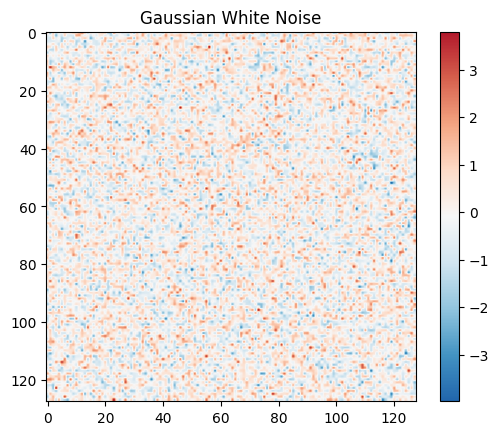

In [89]:
plt.title("Gaussian White Noise")
plt.imshow(RaNois, cmap=cmap)
plt.colorbar()

### 2) FFT that noise

In [90]:
RaNois_ffted = np.fft.fftn(RaNois)

### 3) Extract 2D k-modes from RaNois_ffted

In [91]:
RaNois_kmodes_xy = np.fft.fftfreq(side_length) * 2 * np.pi

### 4) Use meshgrid to put them on the 2D plane to match 2D RaFiel

In [92]:
RaNois_kmodes_x, RaNois_kmodes_y = np.meshgrid(RaNois_kmodes_xy, RaNois_kmodes_xy)

### 5) Generate k-magnitudes and mask out zeros to prevent NaNs in the power spectrum computation

In [93]:
RaNois_kmodes_mag = np.sqrt(RaNois_kmodes_x**2 + RaNois_kmodes_y**2)
k_zero_mask = RaNois_kmodes_mag == 0 # this is true at (0,0) and false everywhere else?

In [94]:
pspec_basic = 0.1 * RaNois_kmodes_mag ** -2 # why is this a power spectrum? Correlation... connected to... kmode size... related to separation...
pspec_basic[k_zero_mask] = 0

/var/folders/57/59_c7jss5dd3jh7w6c724nv80000gn/T/ipykernel_82381/3879781566.py:1: RuntimeWarning: divide by zero encountered in power
  pspec_basic = 0.1 * RaNois_kmodes_mag ** -2 # why is this a power spectrum? Correlation... connected to... kmode size... related to separation...


### 6) Multiple FFTed RaFiel by the square root of the power spectrum

In [95]:
RaFiel_ffted = RaNois_ffted * np.sqrt(pspec_basic)

### 7) Inverse FFT back into real space

When doing this, we need to use ifftn, not ifft. If you don't, the dimensions get fucked.

In [96]:
RaFiel = np.fft.ifftn(RaFiel_ffted) 

### 8) Inverse FFT back into real space

We can just take the real part because the imaginary parts are not supposed to exist. They are really small! These imaginary values are not real (no pun intended) -- they just arise from numerical inaccuracies in your computer, and they don't contain any information about the distribution.

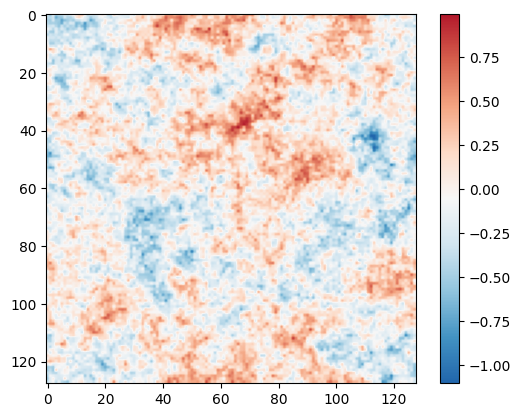

In [97]:
plt.imshow(np.real(RaFiel), cmap=cmap)
plt.colorbar()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fb4bbabe-cce4-40fa-9dba-776cfc222e4b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

Each time you run the above code to generate RaFiel, you will end up with a slightly different field. Try it out and see how the power spectrum, semivariogram, and structure function vary slightly when you do. Below we save the field to the Data folder in our directory.

In [98]:
np.save("Data/RaFiel.npy", RaFiel)

## Thank you for following along for the numerical side of our journey! We recognize that there are much more efficient ways to compute these spatial correlation probes, and we encourage you to explore creating your own or finding some that already exist.